In [80]:
from datetime import datetime, timedelta, timezone
import pandas as pd
from xgboost import XGBRegressor
import hopsworks
import json
import util
import os

download the model, then download the next 7 days weather forecast -make prediction, and dashboard

In [81]:
today = datetime.now() - timedelta(0)
tomorrow = today + timedelta(days = 1)
today

datetime.datetime(2024, 11, 18, 15, 43, 23, 920630)

In [82]:
project = hopsworks.login()
fs = project.get_feature_store() 

secrets = util.secrets_api(project.name)
location_str = secrets.get_secret("SENSOR_LOCATION_JSON").value
location = json.loads(location_str)
country=location['country']
city=location['city']
street=location['street']
url=location['aqicn_url']

Connection closed.
Connected. Call `.close()` to terminate connection gracefully.



Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1157270
Connected. Call `.close()` to terminate connection gracefully.
Connected. Call `.close()` to terminate connection gracefully.


In [83]:
feature_view = fs.get_feature_view(
    name='air_quality_fv',
    version=1,
)

Model registry

In [84]:
mr= project.get_model_registry()

retrieved_model=mr.get_model(
    name="air_quality_xgboost_model",
    version=12,
)

saved_model_dir=retrieved_model.download()

Connected. Call `.close()` to terminate connection gracefully.


In [85]:
retrieved_xgboost_model=XGBRegressor()

retrieved_xgboost_model.load_model(saved_model_dir+"/model.json")

retrieved_xgboost_model

XGBRegressor(base_score='2.4931547E1', booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None,
             feature_types=['float', 'float', 'float', 'float', 'float',
                            'float', 'float'],
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [89]:
weather_fg= fs.get_feature_group(
    name='weather',
    version=1,
)

batch_data= weather_fg.filter(weather_fg.date >= today).read()
batch_data = batch_data.sort_values(by=['date']).reset_index(drop=True)

batch_data

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.67s) 


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city
0,2024-11-18 00:00:00+00:00,2.80,0.0,11.542478,273.576263,stockholm
1,2024-11-19 00:00:00+00:00,1.95,0.0,6.034700,107.354111,stockholm
2,2024-11-20 00:00:00+00:00,1.60,0.0,18.947083,14.300317,stockholm
3,2024-11-21 00:00:00+00:00,-2.65,0.7,28.666941,305.286835,stockholm
4,2024-11-22 00:00:00+00:00,-4.90,0.0,16.622490,287.650208,stockholm
5,2024-11-23 00:00:00+00:00,-4.10,0.0,10.805999,271.909119,stockholm
6,2024-11-24 00:00:00+00:00,3.75,0.0,18.899143,139.635544,stockholm
7,2024-11-25 00:00:00+00:00,6.85,0.0,23.400002,194.250061,stockholm
8,2024-11-26 00:00:00+00:00,3.50,0.1,15.463244,282.094727,stockholm
9,2024-11-27 00:00:00+00:00,0.20,0.0,14.003029,287.969238,stockholm


In [90]:
air_quality_fg= fs.get_feature_group(
    name='air_quality',
    version=1,
)

today=datetime.today() - timedelta(1)     

aq_batch_data= air_quality_fg.filter(air_quality_fg.date >= today).read()       #Only need todays for future predictions. Makes it a dataframe
aq_batch_data = aq_batch_data.sort_values(by=['date']).reset_index(drop=True)

df_combined = pd.concat([aq_batch_data, batch_data], ignore_index=True)
 

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.69s) 


In [91]:
for index in range(len(batch_data)-1):        
    current_day=df_combined.loc[index,['date']]
    print(current_day)

    df_combined.at[index+1,'pm25_3_days_before']=df_combined.loc[index,'pm25_2_days_before']
    df_combined.at[index+1,'pm25_2_days_before']=df_combined.loc[index,'pm25_1_days_before']
    df_combined.at[index+1,'pm25_1_days_before']=df_combined.loc[index,'pm25']
    
    #INSERT AIR QUALITY FEATURES
    # df_combined.at[index+1,'pm25_average_before']=df_combined.loc[index, ["pm25_1_day_before", "pm25_2_days_before", "pm25_3_days_before"]].mean().astype('float32')
    # df_combined.at[index+1,"country"] = country
    # df_combined.at[index+1,"street"] = street
    # df_combined.at[index+1,"url"] = country
    #df["url"] = aqicn_url
    
    current_features=df_combined.loc[index+1, ['pm25_1_days_before', 'pm25_2_days_before','pm25_3_days_before','temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant']]

    current_features = pd.DataFrame(current_features.astype(float)).T

    next_pred=retrieved_xgboost_model.predict(current_features)
    df_combined.at[index+1,'pm25']=next_pred
    batch_data.at[index+1, 'predicted_pm25']=next_pred
    df_combined.at[index+1,'predicted_pm25']=next_pred


df_combined.dropna(inplace=True)        #Remove the first date, today - as it already is registered.
df_combined.info()

#air_quality_fg.insert(df_combined[['city','country','date','pm25','pm25_1_day_before', 'pm25_2_days_before','pm25_3_days_before','pm25_average_before','street','url',]])  #insert air quality to feature store   


date    2024-11-18 00:00:00+00:00
Name: 0, dtype: object
date    2024-11-18 00:00:00+00:00
Name: 1, dtype: object
date    2024-11-19 00:00:00+00:00
Name: 2, dtype: object
date    2024-11-20 00:00:00+00:00
Name: 3, dtype: object
date    2024-11-21 00:00:00+00:00
Name: 4, dtype: object
date    2024-11-22 00:00:00+00:00
Name: 5, dtype: object
date    2024-11-23 00:00:00+00:00
Name: 6, dtype: object
date    2024-11-24 00:00:00+00:00
Name: 7, dtype: object
date    2024-11-25 00:00:00+00:00
Name: 8, dtype: object
<class 'pandas.core.frame.DataFrame'>
Index: 0 entries
Data columns (total 15 columns):
 #   Column                       Non-Null Count  Dtype              
---  ------                       --------------  -----              
 0   date                         0 non-null      datetime64[us, UTC]
 1   pm25                         0 non-null      float32            
 2   country                      0 non-null      object             
 3   city                         0 non-null     

In [92]:
# Drop the first row, as it is today's date
batch_data.dropna(inplace=True)
batch_data

,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,predicted_pm25
1,2024-11-19 00:00:00+00:00,1.95,0.0,6.034700,107.354111,stockholm,25.647543
2,2024-11-20 00:00:00+00:00,1.60,0.0,18.947083,14.300317,stockholm,40.847691
3,2024-11-21 00:00:00+00:00,-2.65,0.7,28.666941,305.286835,stockholm,27.696390
4,2024-11-22 00:00:00+00:00,-4.90,0.0,16.622490,287.650208,stockholm,22.635685
5,2024-11-23 00:00:00+00:00,-4.10,0.0,10.805999,271.909119,stockholm,17.510828
6,2024-11-24 00:00:00+00:00,3.75,0.0,18.899143,139.635544,stockholm,24.601587
7,2024-11-25 00:00:00+00:00,6.85,0.0,23.400002,194.250061,stockholm,27.644672
8,2024-11-26 00:00:00+00:00,3.50,0.1,15.463244,282.094727,stockholm,41.735252
9,2024-11-27 00:00:00+00:00,0.20,0.0,14.003029,287.969238,stockholm,28.337904


In [95]:
batch_data['street'] = street
batch_data['city'] = city
batch_data['country'] = country
batch_data['days_before_forecast_day'] = range(1, len(batch_data)+1)
batch_data = batch_data.sort_values(by=['date'])

In [96]:
batch_data

,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,predicted_pm25,days_before_forecast_day,street,country
1,2024-11-19 00:00:00+00:00,1.95,0.0,6.034700,107.354111,stockholm,25.647543,1,stockholm-st-eriksgatan-83,sweden
2,2024-11-20 00:00:00+00:00,1.60,0.0,18.947083,14.300317,stockholm,40.847691,2,stockholm-st-eriksgatan-83,sweden
3,2024-11-21 00:00:00+00:00,-2.65,0.7,28.666941,305.286835,stockholm,27.696390,3,stockholm-st-eriksgatan-83,sweden
4,2024-11-22 00:00:00+00:00,-4.90,0.0,16.622490,287.650208,stockholm,22.635685,4,stockholm-st-eriksgatan-83,sweden
5,2024-11-23 00:00:00+00:00,-4.10,0.0,10.805999,271.909119,stockholm,17.510828,5,stockholm-st-eriksgatan-83,sweden
6,2024-11-24 00:00:00+00:00,3.75,0.0,18.899143,139.635544,stockholm,24.601587,6,stockholm-st-eriksgatan-83,sweden
7,2024-11-25 00:00:00+00:00,6.85,0.0,23.400002,194.250061,stockholm,27.644672,7,stockholm-st-eriksgatan-83,sweden
8,2024-11-26 00:00:00+00:00,3.50,0.1,15.463244,282.094727,stockholm,41.735252,8,stockholm-st-eriksgatan-83,sweden
9,2024-11-27 00:00:00+00:00,0.20,0.0,14.003029,287.969238,stockholm,28.337904,9,stockholm-st-eriksgatan-83,sweden


In [97]:
batch_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9 entries, 1 to 9
Data columns (total 10 columns):
 #   Column                       Non-Null Count  Dtype              
---  ------                       --------------  -----              
 0   date                         9 non-null      datetime64[us, UTC]
 1   temperature_2m_mean          9 non-null      float32            
 2   precipitation_sum            9 non-null      float32            
 3   wind_speed_10m_max           9 non-null      float32            
 4   wind_direction_10m_dominant  9 non-null      float32            
 5   city                         9 non-null      object             
 6   predicted_pm25               9 non-null      float32            
 7   days_before_forecast_day     9 non-null      int64              
 8   street                       9 non-null      object             
 9   country                      9 non-null      object             
dtypes: datetime64[us, UTC](1), float32(5), int64(1), object(3)


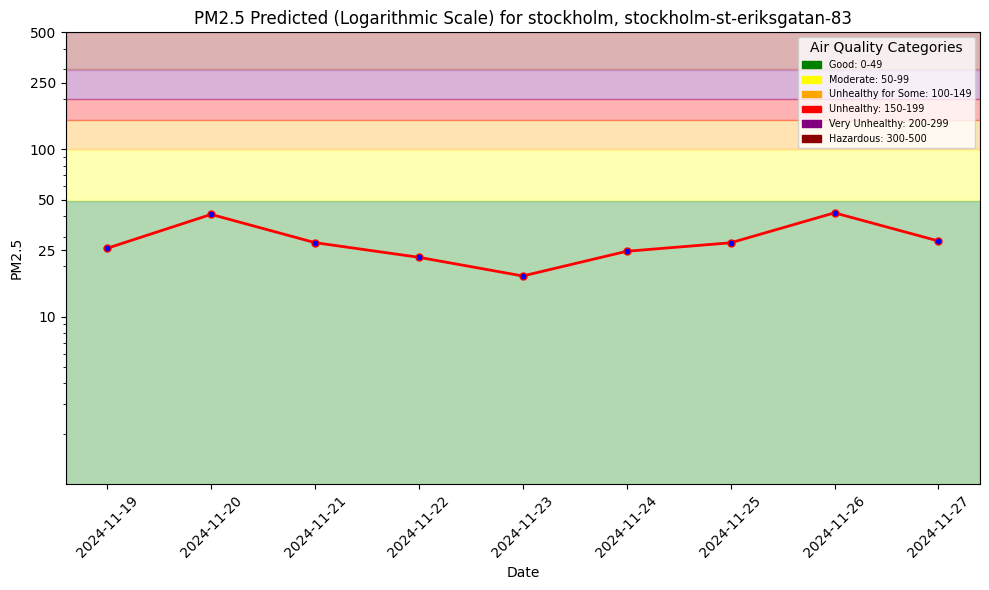

In [98]:
file_path = "docs/air-quality/assets/img/pm25_forecast.png"
plt = util.plot_air_quality_forecast(city, street, batch_data, file_path)
plt.show()

In [99]:
monitor_fg = fs.get_or_create_feature_group(
    name='aq_predictions',
    description='Air Quality prediction monitoring',
    version=1,
    primary_key=['city','street','date','days_before_forecast_day'],
    event_time="date"
)

In [ ]:
print(batch_data.head())
monitor_fg.insert(batch_data, write_options={"wait_for_job": True})

KeyError: "['url'] not found in axis"

In [ ]:
monitoring_df = monitor_fg.filter(monitor_fg.days_before_forecast_day == 1).read()
monitoring_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (4.07s) 


,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,pm25,pm25_1_day_before,pm25_2_days_before,pm25_3_days_before,date,street,city,country,days_before_forecast_day,predicted_pm25
0,7.40,0.0,9.904906,250.906403,25.000000,25.0,21.0,21.0,2024-11-15 00:00:00+00:00,stockholm-st-eriksgatan-83,stockholm,sweden,1,25.000000
1,6.05,0.0,16.071491,254.407120,18.061663,15.0,13.0,22.0,2024-11-17 00:00:00+00:00,stockholm-st-eriksgatan-83,stockholm,sweden,1,18.061663


In [ ]:
air_quality_fg = fs.get_feature_group(
    name='air_quality',
    version=1,
)
air_quality_df = air_quality_fg.read()
air_quality_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.84s) 


,date,pm25,country,city,street,url,pm25_1_day_before,pm25_2_days_before,pm25_3_days_before,pm25_average_before
0,2021-06-27 00:00:00+00:00,24.0,sweden,stockholm,stockholm-st-eriksgatan-83,https://api.waqi.info/feed/@10523,27.0,37.0,26.0,30.000000
1,2023-12-15 00:00:00+00:00,24.0,sweden,stockholm,stockholm-st-eriksgatan-83,https://api.waqi.info/feed/@10523,19.0,21.0,25.0,21.666666
2,2024-09-22 00:00:00+00:00,10.0,sweden,stockholm,stockholm-st-eriksgatan-83,https://api.waqi.info/feed/@10523,19.0,23.0,24.0,22.000000
3,2021-11-09 00:00:00+00:00,20.0,sweden,stockholm,stockholm-st-eriksgatan-83,https://api.waqi.info/feed/@10523,14.0,9.0,13.0,12.000000
4,2021-04-24 00:00:00+00:00,9.0,sweden,stockholm,stockholm-st-eriksgatan-83,https://api.waqi.info/feed/@10523,12.0,17.0,26.0,18.333334
...,...,...,...,...,...,...,...,...,...,...
2134,2019-03-24 00:00:00+00:00,25.0,sweden,stockholm,stockholm-st-eriksgatan-83,https://api.waqi.info/feed/@10523,31.0,28.0,26.0,28.333334
2135,2020-03-13 00:00:00+00:00,17.0,sweden,stockholm,stockholm-st-eriksgatan-83,https://api.waqi.info/feed/@10523,16.0,26.0,33.0,25.000000
2136,2021-01-18 00:00:00+00:00,26.0,sweden,stockholm,stockholm-st-eriksgatan-83,https://api.waqi.info/feed/@10523,18.0,16.0,20.0,18.000000
2137,2024-11-17 00:00:00+00:00,15.0,sweden,stockholm,stockholm-st-eriksgatan-83,https://api.waqi.info/feed/@10523,13.0,22.0,25.0,20.000000


In [ ]:
outcome_df = air_quality_df[['date', 'pm25']]
preds_df =  monitoring_df[['date', 'predicted_pm25']]

hindcast_df = pd.merge(preds_df, outcome_df, on="date")
hindcast_df = hindcast_df.sort_values(by=['date'])

# If there are no outcomes for predictions yet, generate some predictions/outcomes from existing data
if len(hindcast_df) == 0:
    hindcast_df = util.backfill_predictions_for_monitoring(weather_fg, air_quality_df, monitor_fg, retrieved_xgboost_model)
hindcast_df

,date,predicted_pm25,pm25
0,2024-11-15 00:00:00+00:00,25.000000,22.0
1,2024-11-17 00:00:00+00:00,18.061663,15.0


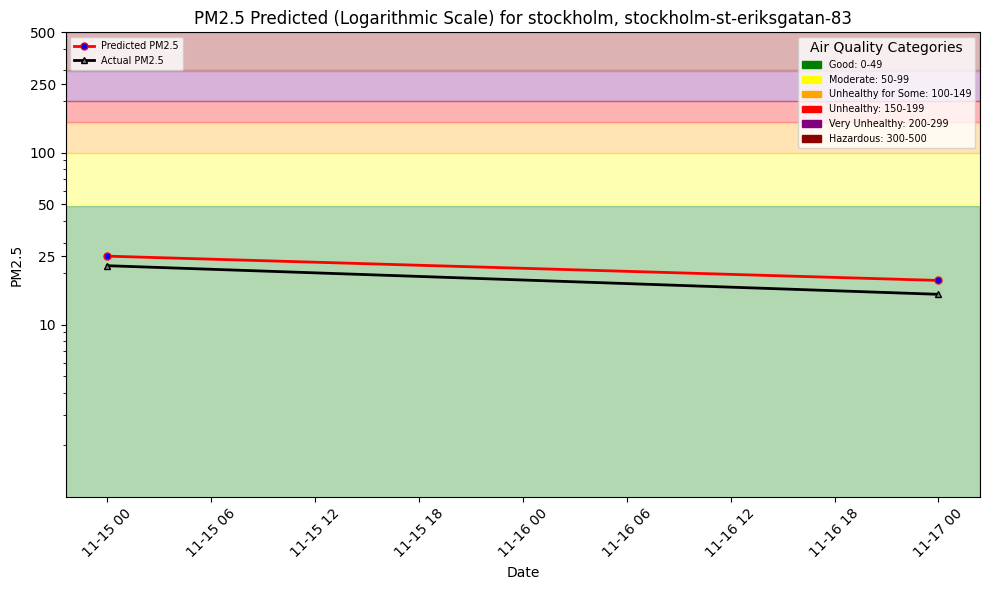

In [ ]:
file_path = "docs/air-quality/assets/img/pm25_hindcast_1day.png"
plt = util.plot_air_quality_forecast(city, street, hindcast_df, file_path, hindcast=True)
plt.show()